Add imports, define hyperparameter variables and load the dataset.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.mps.manual_seed(0)
np.random.seed(0)

BATCH_SIZE = 64
LOOKBACK_LENGTH = 30
TEST_LENGTH = 365
DROPOUT = 0.2
HIDDEN_SIZE = 256
NUM_LAYERS = 3
OUTPUT_SIZE = 1
LEARNING_RATE = 0.001
EPOCHS = 110

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and sort the data
data = pd.read_csv("../data/BTC Data 2013-12-27 2025-04-01.csv")
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

print(f"Data range: {data['date'].min()} to {data['date'].max()}")
print(f"Total samples: {len(data)}")

Using device: cuda
Data range: 2013-12-27 00:00:00 to 2025-04-01 00:00:00
Total samples: 4114


Feature engineer some extra features for monthly and weekly cyclic trends in the Bitcoin history.

In [18]:
data['dayOfWeek'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month

Choose the features and targets. Normalize the dataset.

In [19]:
feature_columns = ['open', 'high', 'low', 'volume', 'dayOfWeek', 'month']
target_column = 'close'

X = data[feature_columns].values
y = data[target_column].values.reshape(-1, 1)

X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = X_scaler.fit_transform(X)
y_normalized = y_scaler.fit_transform(y)

Create custom dataset with the timeseries sequences.

In [20]:
class TimeSeriesDataset(Dataset):
	def __init__(self, X, y):
		self.X = torch.FloatTensor(X)
		self.y = torch.FloatTensor(y)

	def __len__(self):
		return len(self.X)

	def __getitem__(self, i):
		return self.X[i], self.y[i]

def create_sequences(X, y, seq_length):
	X_seq, y_seq = [], []
	
	for i in range(len(X) - seq_length):
		X_seq.append(X[i:i + seq_length])
		y_seq.append(y[i + seq_length])
		
	return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_normalized, y_normalized, LOOKBACK_LENGTH)

test_dates = data['date'].iloc[-TEST_LENGTH:]

train_dataset = TimeSeriesDataset(X_seq[:-TEST_LENGTH], y_seq[:-TEST_LENGTH])
test_dataset = TimeSeriesDataset(X_seq[-TEST_LENGTH:], y_seq[-TEST_LENGTH:])

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train samples: 3719
Test samples: 365


Create the LSTM model.

In [21]:
class LSTMPrediction(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
		super(LSTMPrediction, self).__init__()

		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)

		self.fc = nn.Linear(hidden_size, output_size)

	def forward(self, x):
		output, _ = self.lstm(x)
		output = self.fc(output[:, -1, :])
		return output

model = LSTMPrediction(len(feature_columns), HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT).to(device)
print(model)

LSTMPrediction(
  (lstm): LSTM(6, 256, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


Define loss function and Adam optimizer. Train the model. Make sure to always define the model with the code above before running.

In [22]:
def train(model, train_loader, criterion, optimizer, epochs=EPOCHS):
	train_losses = []

	for epoch in range(epochs):
		model.train()
		train_loss = 0
		for X_batch, y_batch in train_loader:
			X_batch = X_batch.to(device)
			y_batch = y_batch.to(device)
	
			# Predict the output
			y_pred = model(X_batch)
			loss = criterion(y_pred, y_batch)

			# Reset gradients, calculate new ones and update model parameters
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			train_loss += loss.item()

		train_loss /= len(train_loader)
		train_losses.append(train_loss)
		print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")

	return model, train_losses

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model, train_losses = train(model, train_loader, criterion, optimizer, EPOCHS)
loaded = None

Epoch 1/110, Train Loss: 0.089855
Epoch 2/110, Train Loss: 0.001863
Epoch 3/110, Train Loss: 0.001585
Epoch 4/110, Train Loss: 0.001515
Epoch 5/110, Train Loss: 0.001521
Epoch 6/110, Train Loss: 0.001318
Epoch 7/110, Train Loss: 0.001265
Epoch 8/110, Train Loss: 0.001246
Epoch 9/110, Train Loss: 0.001175
Epoch 10/110, Train Loss: 0.001168
Epoch 11/110, Train Loss: 0.001117
Epoch 12/110, Train Loss: 0.001010
Epoch 13/110, Train Loss: 0.001050
Epoch 14/110, Train Loss: 0.001062
Epoch 15/110, Train Loss: 0.001026
Epoch 16/110, Train Loss: 0.001010
Epoch 17/110, Train Loss: 0.000912
Epoch 18/110, Train Loss: 0.000880
Epoch 19/110, Train Loss: 0.000925
Epoch 20/110, Train Loss: 0.000871
Epoch 21/110, Train Loss: 0.000905
Epoch 22/110, Train Loss: 0.000930
Epoch 23/110, Train Loss: 0.000892
Epoch 24/110, Train Loss: 0.000784
Epoch 25/110, Train Loss: 0.000734
Epoch 26/110, Train Loss: 0.000795
Epoch 27/110, Train Loss: 0.000791
Epoch 28/110, Train Loss: 0.000819
Epoch 29/110, Train Loss: 0.0

Save the trained model to file. Uncomment the next code line to save the weights to a file.

In [ ]:
#torch.save(model.state_dict(), f"../weights/od_lstm-{NUM_LAYERS}l-{HIDDEN_SIZE}hs-{DROPOUT}d-{LOOKBACK_LENGTH}lb-{EPOCHS}e-{BATCH_SIZE}bs-ohlvdm.pth")

Load a pretrained model and set loaded to true for graph printing. Uncomment these lines to use a pretrained model.

In [ ]:
"""
model.load_state_dict(torch.load("../weights/od_lstm-3l-256hs-0.2d-30lb-110e-64bs-ohlvdm.pth"))
loaded = True
criterion = nn.MSELoss()
"""

Evaluate the model with different losses.

In [27]:
def evaluate(model, test_loader, criterion):
	model.eval()
	test_loss = 0
	predictions = []
	truths = []

	with torch.no_grad():
		for X_batch, y_batch in test_loader:
			X_batch = X_batch.to(device)
			y_batch = y_batch.to(device)
	
			y_pred = model(X_batch)
			loss = criterion(y_pred, y_batch)

			test_loss += loss.item()

			# Add the predicted and actual values for plotting
			# Move to the CPU and convert the tensor to a numpy array
			predictions.append(y_pred.cpu().numpy())
			truths.append(y_batch.cpu().numpy())

	test_loss /= len(test_loader)

	predictions = np.concatenate(predictions, axis=0)
	truths = np.concatenate(truths, axis=0)

	mse = np.mean((predictions - truths) ** 2)
	rmse = np.sqrt(mse)
	mae = np.mean(np.abs(predictions - truths))
	mape = np.mean(np.abs((truths - predictions) / truths))

	if loaded == None:
		print(f"Train Loss: {train_losses[-1]:.6f}")
	print(f"Test Loss: {test_loss:.6f}")

	print("\nNormalized")
	print(f"MSE: {mse:.6f}")
	print(f"RMSE: {rmse:.6f}")
	print(f"MAE: {mae:.6f}")
	print(f"MAPE: {mape:.6f}")

	# Inverse the normalization to get the actual BTC prices
	predictions = y_scaler.inverse_transform(predictions)
	truths = y_scaler.inverse_transform(truths)

	mse = np.mean((predictions - truths) ** 2)
	rmse = np.sqrt(mse)
	mae = np.mean(np.abs(predictions - truths))
	mape = np.mean(np.abs((truths - predictions) / truths))
	print("\nUnnormalized")
	print(f"MSE: {mse:.6f}")
	print(f"RMSE: {rmse:.6f}")
	print(f"MAE: {mae:.6f}")
	print(f"MAPE: {mape:.6f}")

	return predictions, truths

predictions, actuals = evaluate(model, test_loader, criterion)

Train Loss: 0.000402
Test Loss: 0.002343

Normalized
MSE: 0.002262
RMSE: 0.047561
MAE: 0.035825
MAPE: 0.158169

Unnormalized
MSE: 6350312.000000
RMSE: 2519.982422
MAE: 1898.156860
MAPE: 0.024825


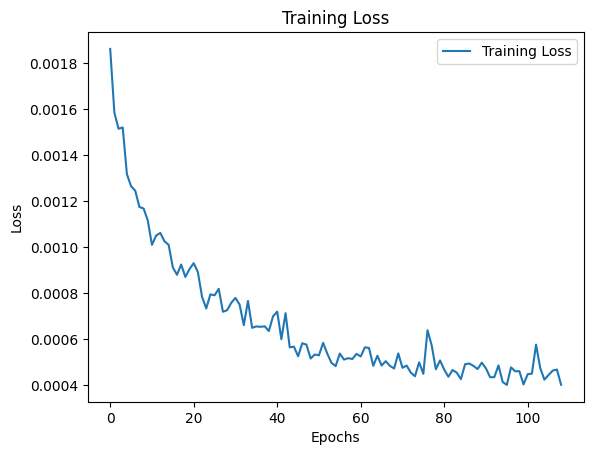

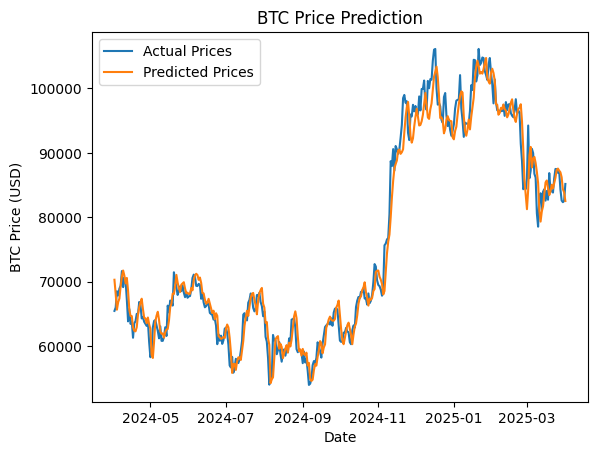

In [26]:

if loaded == None:
	plt.plot(train_losses[1:], label='Training Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training Loss')
	plt.legend()
	plt.show()

plt.plot(test_dates, actuals, label='Actual Prices')
plt.plot(test_dates, predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()